In [109]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.stats as spstats

In [110]:
#data
n = 10
np.random.seed(1)
mu = np.abs(np.random.randn(n,1))
sigma = np.random.randn(n,n)
sigma = sigma.T @ sigma

In [111]:
# long only portfolio optimization
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk  = cp.quad_form(w,sigma)
prob = cp.Problem(cp.Minimize(gamma * risk - ret),[cp.sum(w) == 1, w  >= 0])

In [112]:
from tqdm.auto import tqdm
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_val = np.logspace(-2,3,num=SAMPLES)
for i in tqdm(range(SAMPLES)):
  gamma.value = gamma_val[i]
  prob.solve()
  risk_data[i] = cp.sqrt(risk).value
  ret_data[i] = ret.value

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-112-8716f14931f9>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_data[i] = ret.value


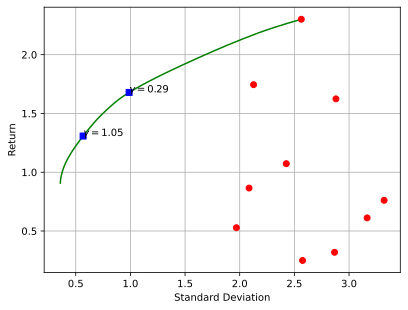

In [113]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29,40]
fig  = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data,ret_data,'g-')
for markers in markers_on:
  plt.plot(risk_data[markers],ret_data[markers],'bs')
  plt.annotate(r"$\gamma = %.2f$" % gamma_val[markers],xy=(risk_data[markers],ret_data[markers]))
for i in range(n):
  plt.plot(cp.sqrt(sigma[i][i]).value,mu[i],'ro')
plt.grid(True)
plt.xlabel("Standard Deviation")
plt.ylabel("Return")
plt.show()

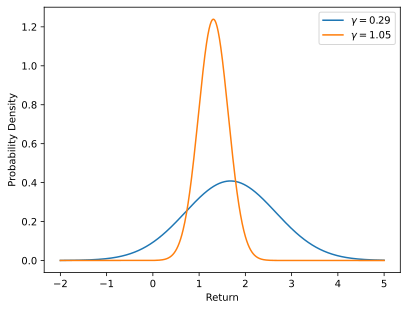

In [114]:
plt.figure()
for index, rav in enumerate(markers_on):
  gamma.value = gamma_val[rav]
  prob.solve()
  x = np.linspace(-2,5,1000)
  plt.plot(x,spstats.norm.pdf(x,ret.value,risk.value),label=r"$\gamma = %.2f$" % gamma_val[rav])
plt.xlabel("Return")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper right')
plt.show()

In [115]:
Lmax = cp.Parameter()
prob = cp.Problem(cp.Maximize(ret - gamma * risk),
                  [cp.sum(w) == 1, cp.norm(w,1) <= Lmax])

In [116]:
L_vals = [1,2,4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals),SAMPLES))
ret_data = np.zeros((len(L_vals),SAMPLES))
gamma_val = np.logspace(-2,3,num = SAMPLES)
for i, levarage in enumerate(L_vals):
  for j in range(SAMPLES):
    Lmax.value = levarage
    gamma.value = gamma_val[j]
    prob.solve(solver = cp.CVXOPT)
    risk_data[i,j] = cp.sqrt(risk).value
    ret_data[i,j] = ret.value

<ipython-input-116-8d7f5c05c038>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_data[i,j] = ret.value


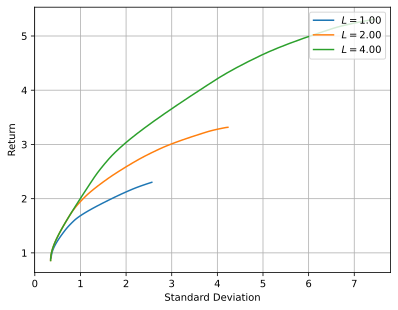

In [117]:
for idx, Lvalue in enumerate(L_vals):
  plt.plot(risk_data[idx,:],ret_data[idx,:],label=r"$L = %.2f$" % Lvalue)
plt.xlabel("Standard Deviation")
plt.ylabel("Return")
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

Portfolio Optimization for the levrage limit and bound on risk

In [118]:
prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1,
                   cp.norm(w,1) <= Lmax,
                   risk <= 2])

In [119]:
w_vals = []
for i, levarage in enumerate(L_vals):
  Lmax.value = levarage
  prob.solve()
  w_vals.append(w.value)

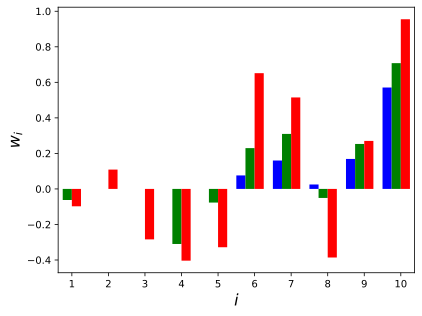

In [120]:
colors = ['b','g','r']
indices = np.argsort(mu.flatten())
for idx,lev in enumerate(L_vals):
  plt.bar(np.arange(1,n+1) + 0.25 * idx - 0.375, w_vals[idx][indices],color=colors[idx],width=0.25,label = r"$L^{\max}$ = %d" % lev)
plt.ylabel(r"$w_i$",fontsize = 16)
plt.xlabel(r"$i$",fontsize = 16)
plt.xlim([1-0.375,10+0.375])
plt.xticks(np.arange(1,n+1))
plt.show()

Factor Covariance Model vs Single Matrix Covariance

In [121]:
n = 3000
k = 50
np.random.seed(10)
mu = np.abs(np.random.randn(n,1))
sigma_tilde = np.random.randn(k,k)
sigma_tilde = sigma_tilde.T @ sigma_tilde
D = np.diag(np.random.uniform(0,0.9,size=n))
F = np.random.randn(n,k)

In [122]:
w = cp.Variable(n)
f = F.T @ w
gamma = cp.Parameter(nonneg=True)
Lmax = cp.Parameter()
ret = mu.T @ w
risk = cp.quad_form(f,sigma_tilde) + cp.quad_form(w,D)
prob_factor = cp.Problem(cp.Maximize(ret - gamma * risk),
                  [
                      cp.sum(w) == 1,
                      cp.norm(w,1) <= Lmax
                  ])

In [123]:
Lmax.value = 2
gamma.value = 0.1
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 30 05:40:45 PM: Your problem has 10 variables, 3 constraints, and 1 parameters.
(CVXPY) Dec 30 05:40:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 30 05:40:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 30 05:40:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 30 05:40:45 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Dec 30 05:40:45 PM: Finished problem compilation (took 4.611e-03 seconds).
-------------------

2.5214535663665645

In [ ]:
#Using simple method of covariance matrix
risk = cp.quad_form(w,F @ sigma_tilde @ F.T  + D)
prob  = cp.Problem(cp.Maximize(ret - gamma * risk),
                  [
                      cp.sum(w) == 1,
                      cp.norm(w,1) <= Lmax
                  ])
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 30 06:36:25 PM: Your problem has 3000 variables, 2 constraints, and 2 parameters.


In [ ]:
print('Factor model solve time = {}'.format(prob_factor.solver_stats.solve_time))
print('Single model solve time = {}'.format(prob.solver_stats.solve_time))